In [606]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.animation as animation
import matplotlib.pyplot as plt


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [1155]:
bs = 120

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)
train1 = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
train0 = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
train2 = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)

a= 5 
b = 8 #biased controlled
c = 9
# idx = (train_dataset.targets==1) | (train_dataset.targets==0)
# train_dataset.targets = train_dataset.targets[idx]
# train_dataset.data = train_dataset.data[idx]
idx = train_dataset.targets == a
train1.targets = train_dataset.targets[idx]
train1.data = train_dataset.data[idx]

idx = train_dataset.targets == b   #variable
train0.targets = train_dataset.targets[idx]
train0.data = train_dataset.data[idx]

idx = train_dataset.targets == c
train2.targets = train_dataset.targets[idx]
train2.data = train_dataset.data[idx]
#take two datasets of 0's and 1's seperately . 
#create new #ther to training.
#

#CONTROL THE SIZE OF BATCHES, CHANGE THE DATALOADER1
bs_var = 20
bs_next = int((bs - bs_var)/2)
dataloader0 = torch.utils.data.DataLoader(dataset=train0, batch_size=bs_var, drop_last=True, shuffle=True)
dataloader1 =  torch.utils.data.DataLoader(dataset=train1, batch_size=bs_next, drop_last=True, shuffle=True)
dataloader3 =   torch.utils.data.DataLoader(dataset=train2, batch_size=bs_next, drop_last=True, shuffle=True)



# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

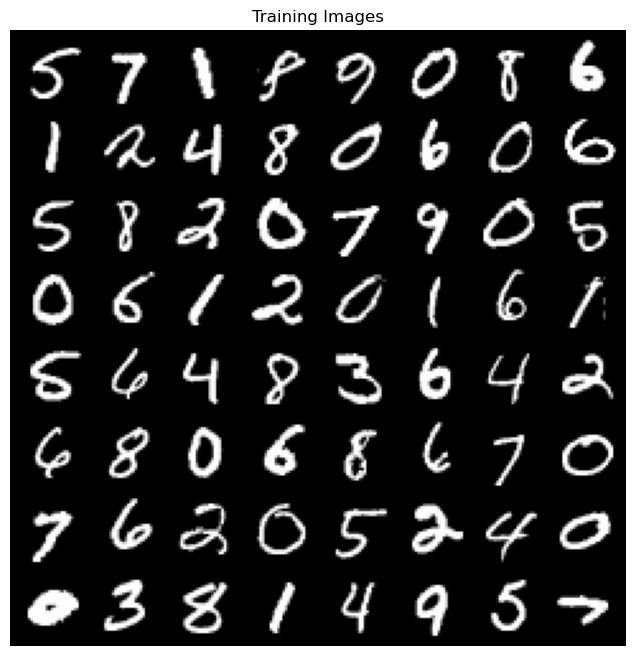

In [1156]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [1157]:
def customdata(d1,d2,d3):
    dataset = []
    tensor_data = []
    for i, ((x,a),(y,b),(q,c)) in enumerate(zip(d1,d2,d3)):

            
        r = torch.cat((x,y,q),0)
        tensor_data.append(r)
        
    return tensor_data
    

In [1158]:
ds = customdata(dataloader0,dataloader1,dataloader3)

In [1159]:
ds[-1].shape

torch.Size([120, 1, 28, 28])

In [1160]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [1161]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

In [1162]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [1163]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [1164]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = Variable(torch.randn(bs, z_dim).to(device))  #
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device)) #can be the not random for other study evaluation to visually inspect if case
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [1165]:
n_epoch = 200
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, x in enumerate(ds):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))
        if batch_idx ==99:
            
            break
        

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/200]: loss_d: 0.992, loss_g: 1.138
[2/200]: loss_d: 1.125, loss_g: 2.624
[3/200]: loss_d: 0.650, loss_g: 4.507
[4/200]: loss_d: 0.025, loss_g: 7.467
[5/200]: loss_d: 0.126, loss_g: 8.385
[6/200]: loss_d: 0.033, loss_g: 9.218
[7/200]: loss_d: 0.049, loss_g: 9.307
[8/200]: loss_d: 0.187, loss_g: 13.933
[9/200]: loss_d: 0.229, loss_g: 8.231
[10/200]: loss_d: 0.080, loss_g: 11.873
[11/200]: loss_d: 0.012, loss_g: 13.058
[12/200]: loss_d: 0.057, loss_g: 17.338
[13/200]: loss_d: 0.109, loss_g: 9.427
[14/200]: loss_d: 0.127, loss_g: 9.221
[15/200]: loss_d: 0.134, loss_g: 9.787
[16/200]: loss_d: 0.276, loss_g: 8.274
[17/200]: loss_d: 0.345, loss_g: 5.890
[18/200]: loss_d: 0.576, loss_g: 4.169
[19/200]: loss_d: 0.475, loss_g: 4.274
[20/200]: loss_d: 0.500, loss_g: 3.831
[21/200]: loss_d: 0.354, loss_g: 3.937
[22/200]: loss_d: 0.299, loss_g: 4.625
[23/200]: loss_d: 0.176, loss_g: 5.820
[24/200]: loss_d: 0.165, loss_g: 5.031
[25/200]: loss_d: 0.272, loss_g: 5.269
[26/200]: loss_d: 0.306, loss_

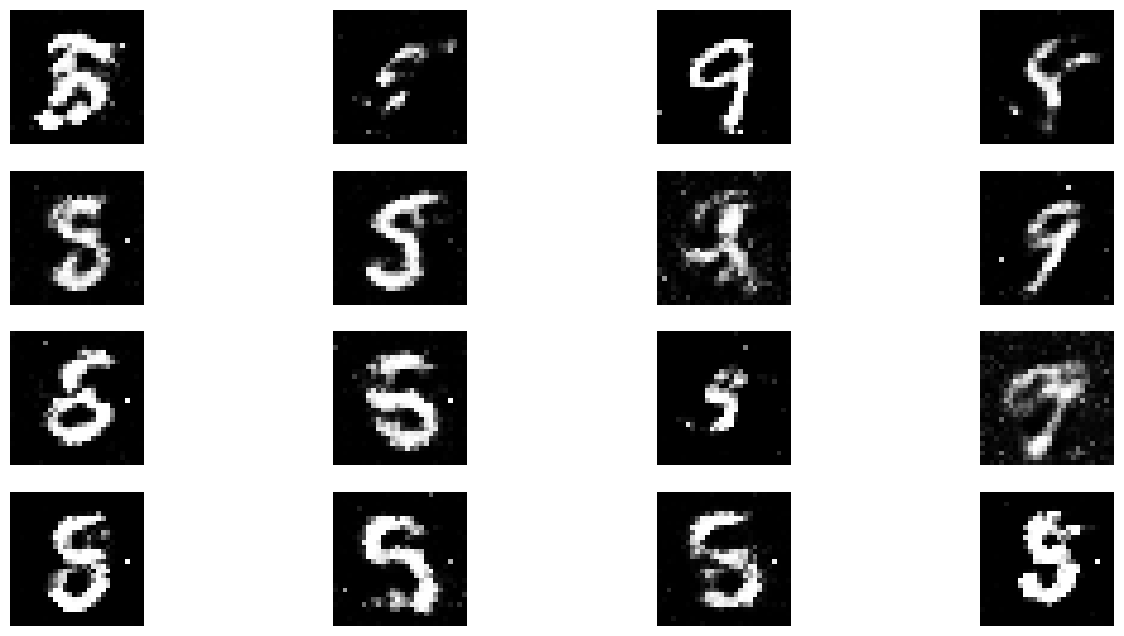

In [1166]:
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    
    
predictions = G(test_z).detach().cpu()

predictions_gen = predictions.reshape(bs,28,28,1)

for i in range(predictions_gen.shape[0]):
    if i < 16:
        plt.subplot(4, 4, i+1)
    plt.imshow(predictions_gen[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    # plt.imsave('samples01/image{:04d}-{}.png'.format(1, i), predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')

    plt.axis('off')
        
gen_images= torch.chunk(predictions_gen,bs,dim=0)
# plt.savefig('image_at_epoch_{:04d}.png'.format(303))


In [1167]:
generated = predictions_gen.reshape(bs,1,28,28)

In [1168]:
cnn.eval()
with torch.no_grad():
    test_output, last_layer = cnn(generated)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()

In [1073]:
pred_y

tensor([5, 5, 5, 9, 9, 9, 9, 5, 5, 5, 9, 6, 5, 5, 5, 9, 5, 3, 5, 9, 5, 9, 9, 5,
        5, 5, 5, 9, 9, 5, 3, 5, 9, 5, 8, 5, 9, 5, 5, 5, 9, 5, 7, 5, 9, 8, 2, 9,
        5, 5, 5, 9, 9, 5, 5, 9, 5, 5, 9, 9, 9, 9, 9, 9, 3, 5, 5, 9, 5, 5, 5, 5,
        9, 5, 5, 5, 9, 5, 9, 5, 9, 5, 5, 9, 5, 9, 5, 5, 5, 5, 9, 9, 5, 9, 5, 5,
        9, 5, 5, 9, 9, 5, 5, 9, 5, 9, 5, 9, 9, 5, 5, 5, 5, 9, 5, 9, 9, 9, 9, 5])

In [1081]:

# gen1 = []
# gen2 =[]
# gen3 = []

In [1075]:
c

9

In [1076]:
gen_c1 = 0
gen_c0 =0
gen_c3 = 0
for i in pred_y:
    if i == b: 
        gen_c0 += 1
    if i == a:
        gen_c1 += 1
    if i ==c:
        gen_c3 +=1
        
list= [gen_c0,gen_c1,gen_c3]

gen1.append(gen_c0) #variable
gen2.append(gen_c1) 
gen3.append(gen_c3)
        

In [1111]:
if len(gen1)%5 ==0:
    print("change batch size")
len(gen1)


change batch size


5

In [1083]:
gen1

[2, 4, 6, 3, 1]

In [998]:
stat = []
mean_stat=[]
std_stat = []
for i in range(len(gen1)):
    stat.append(gen1[i])
    
    if (i+1)%5== 0 and i != 0:
        mean_stat.append(np.mean(stat))
        var = np.var(stat)
        std_stat.append(var ** 0.5)
        stat = []
        
        

In [999]:
std_stat

[0.7483314773547882,
 1.16619037896906,
 5.035871324805669,
 3.4871191548325386,
 5.549774770204643,
 4.069397989875161]

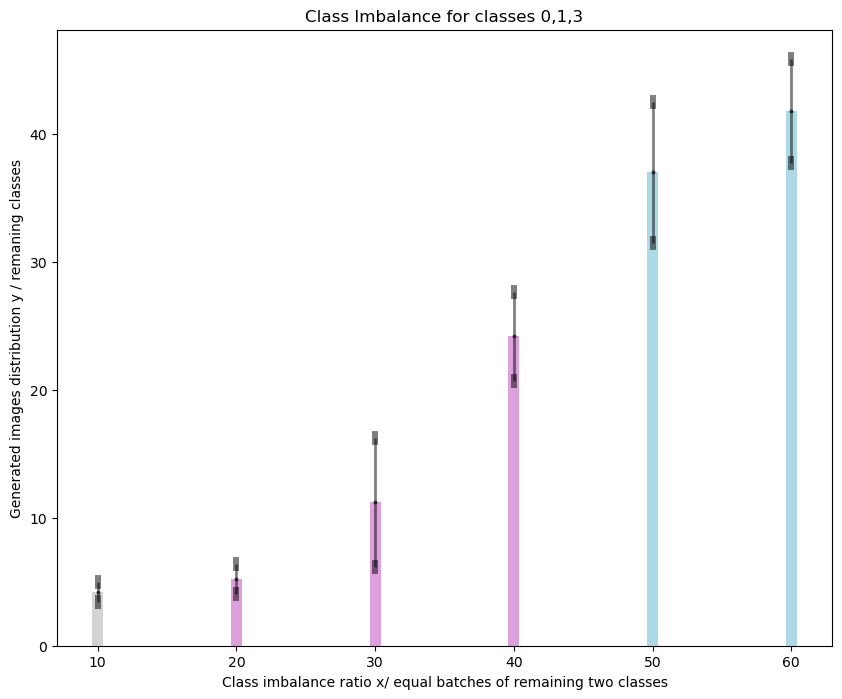

In [1000]:
import matplotlib.pyplot as plt 
x=[10,20,30,40,50,60]
y= mean_stat
yerr=std_stat
width = 10
height = 8
plt.figure(figsize=(width, height))
plt.bar(x, y, color=['lightgray','plum','plum','plum','lightblue','lightblue','lightblue','palegreen','palegreen','palegreen', 'khaki', 'khaki', 'khaki'])
plt.title('Class Imbalance for classes 0,1,3')
plt.xlabel('Class imbalance ratio x/ equal batches of remaining two classes')
plt.ylabel('Generated images distribution y / remaning classes')
plt.errorbar(x, y, yerr, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
plt.savefig('figure.png', dpi=400, transparent=True)
plt.show()

#Performing Classification of the Generated Images 

In [42]:
#dont run below cell

In [1144]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
   

    def __init__(self, im_chan=1, output_chan=32, hidden_dim=16):
        super(Encoder, self).__init__()
        self.z_dim = output_chan
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, output_chan * 2, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        
        disc_pred = self.disc(image)
        encoding = disc_pred.view(len(disc_pred), -1)
        # The stddev output is treated as the log of the variance of the normal 
        # distribution by convention and for numerical stability
        return encoding[:, :self.z_dim], encoding[:, self.z_dim:].exp()

class Decoder(nn.Module):
    
    
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
       
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Sigmoid(),
            )

    def forward(self, noise):
       
    
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

In [1145]:
from torch.distributions.normal import Normal

class VAE(nn.Module):
   
    
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encode = Encoder(im_chan, z_dim)
        self.decode = Decoder(z_dim, im_chan)

    def forward(self, images):
        
        q_mean, q_stddev = self.encode(images)
        q_dist = Normal(q_mean, q_stddev)
        z_sample = q_dist.rsample() # Sample once from each distribution, using the `rsample` notation
        decoding = self.decode(z_sample)
        return decoding, q_dist

In [1146]:
reconstruction_loss = nn.BCELoss(reduction='sum')

In [1147]:
from torch.distributions.kl import kl_divergence
def kl_divergence_loss(q_dist):
    return kl_divergence(
        q_dist, Normal(torch.zeros_like(q_dist.mean), torch.ones_like(q_dist.stddev))
    ).sum(-1)

Epoch 0


100%|██████████| 98/98 [00:00<00:00, 172.37it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


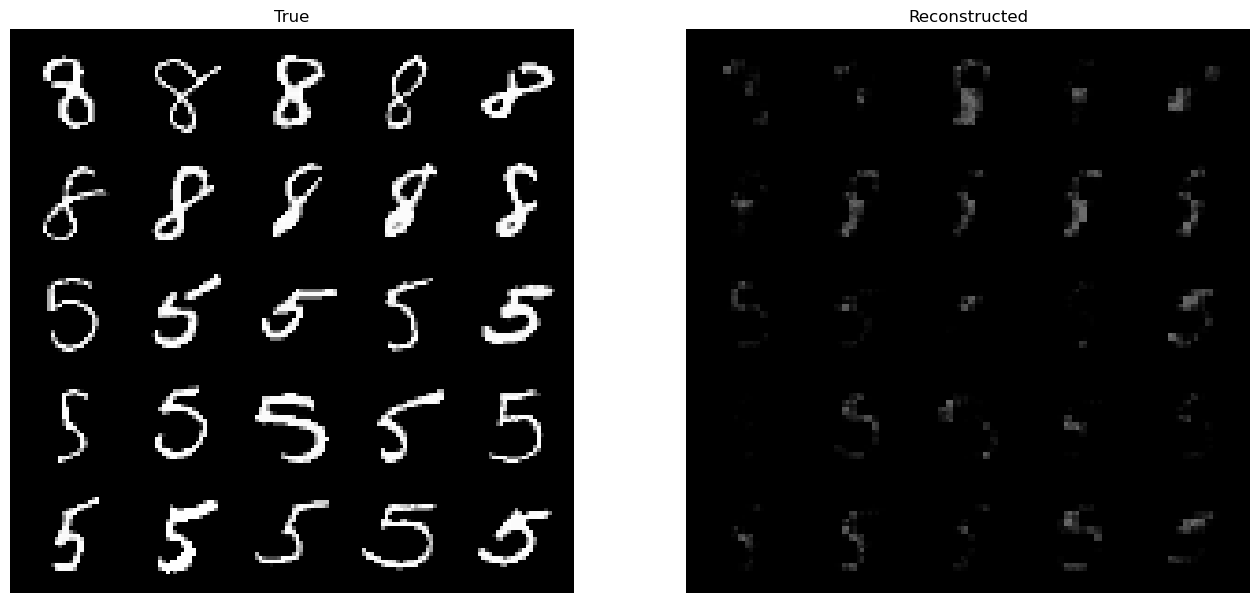

Epoch 1


100%|██████████| 98/98 [00:00<00:00, 169.56it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


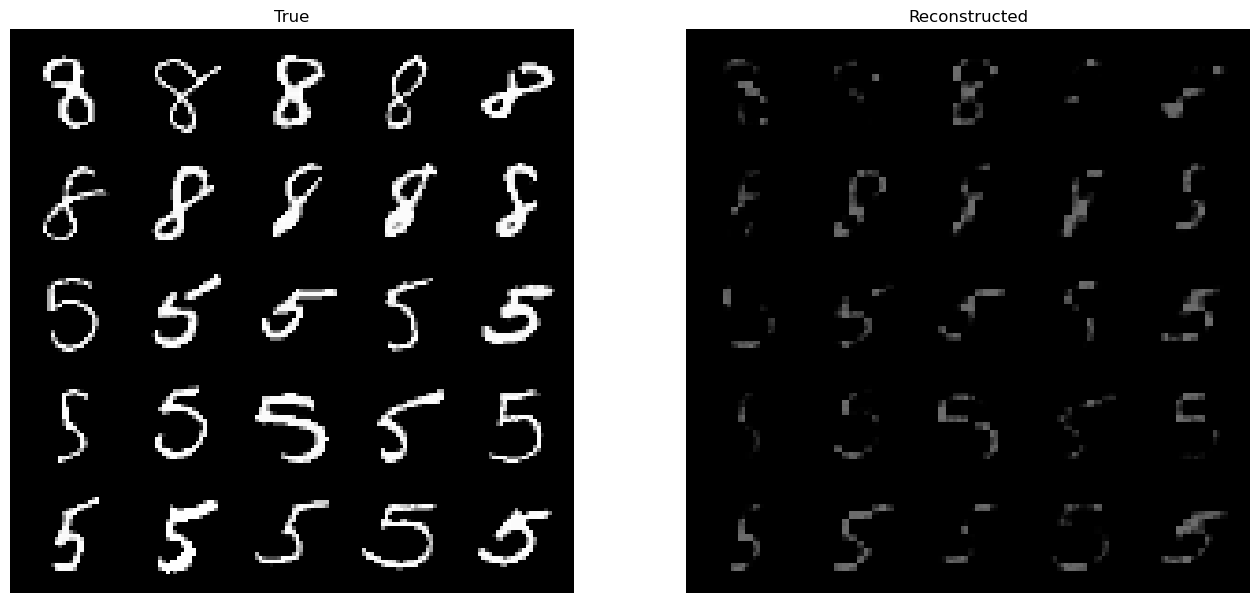

Epoch 2


100%|██████████| 98/98 [00:00<00:00, 173.84it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


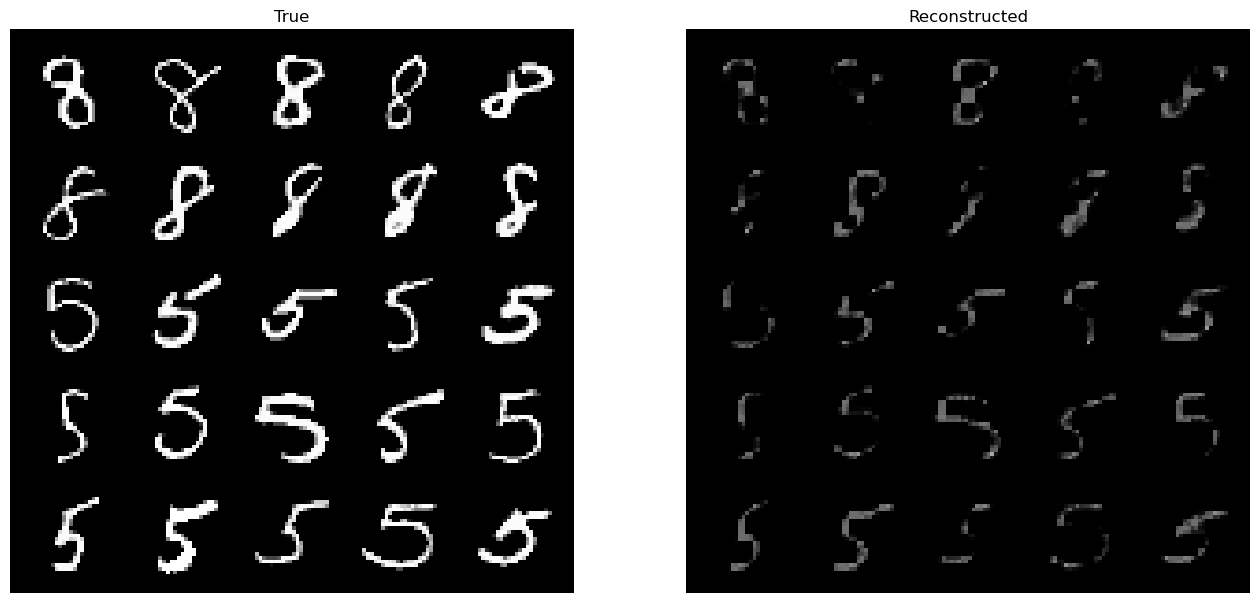

Epoch 3


100%|██████████| 98/98 [00:00<00:00, 172.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


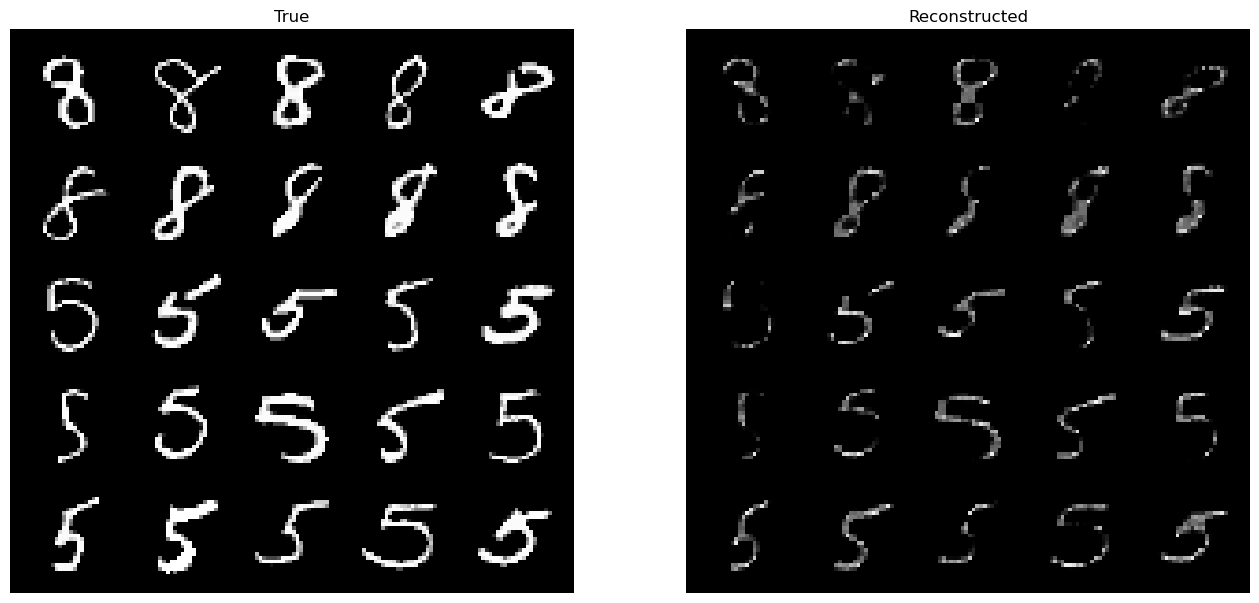

Epoch 4


100%|██████████| 98/98 [00:00<00:00, 170.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


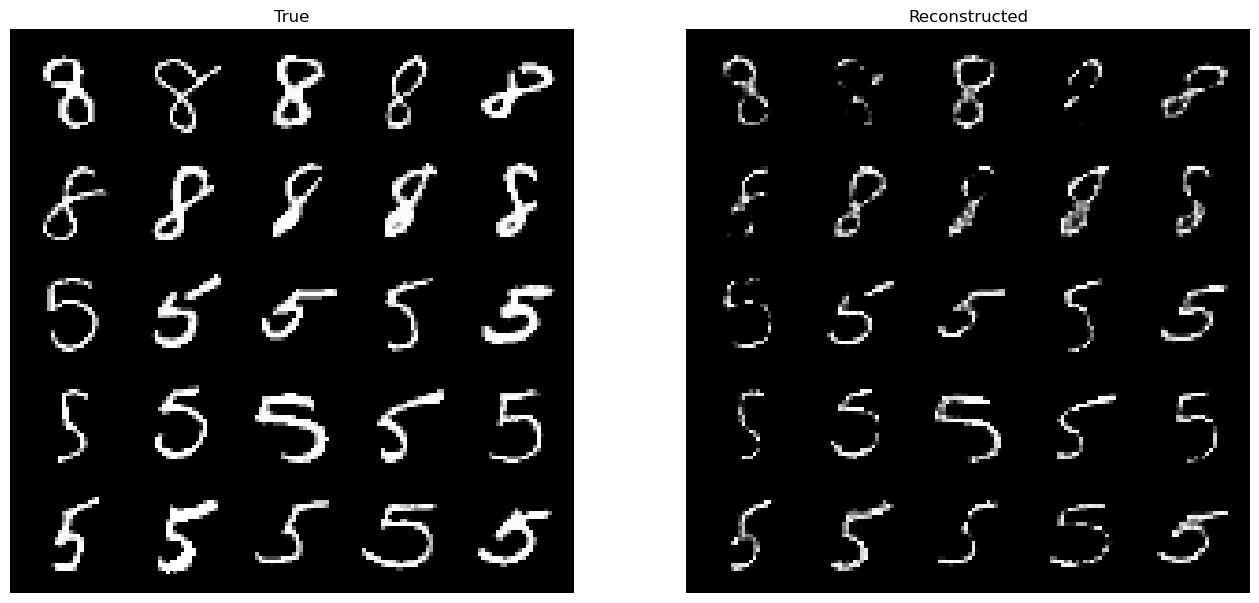

Epoch 5


100%|██████████| 98/98 [00:00<00:00, 174.98it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


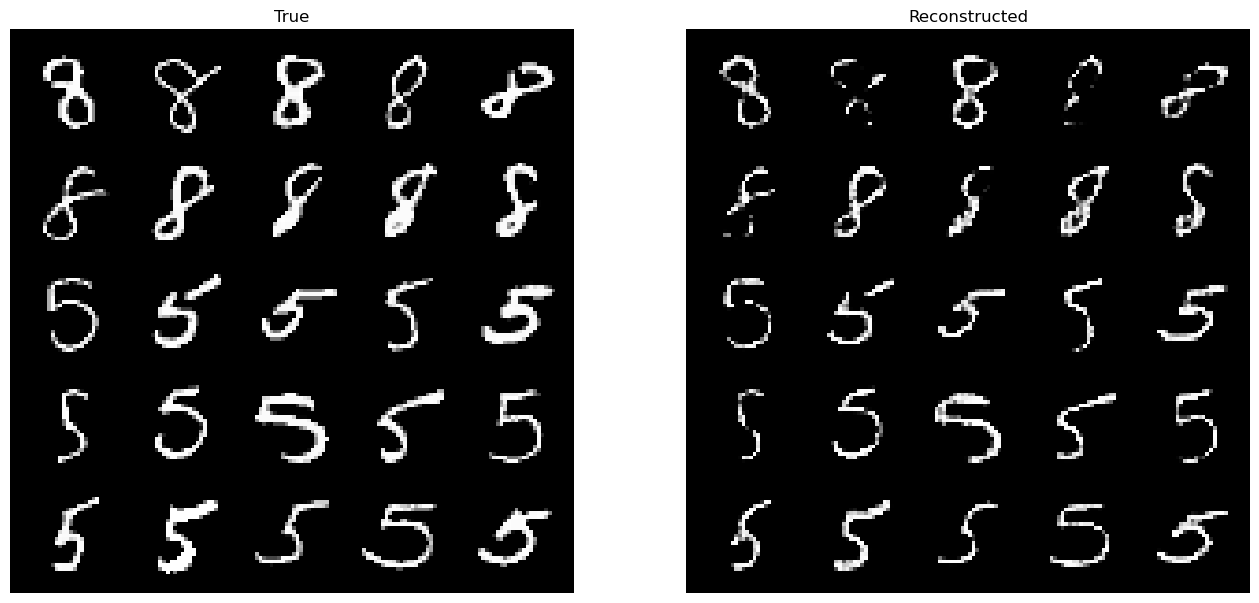

Epoch 6


100%|██████████| 98/98 [00:00<00:00, 173.88it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


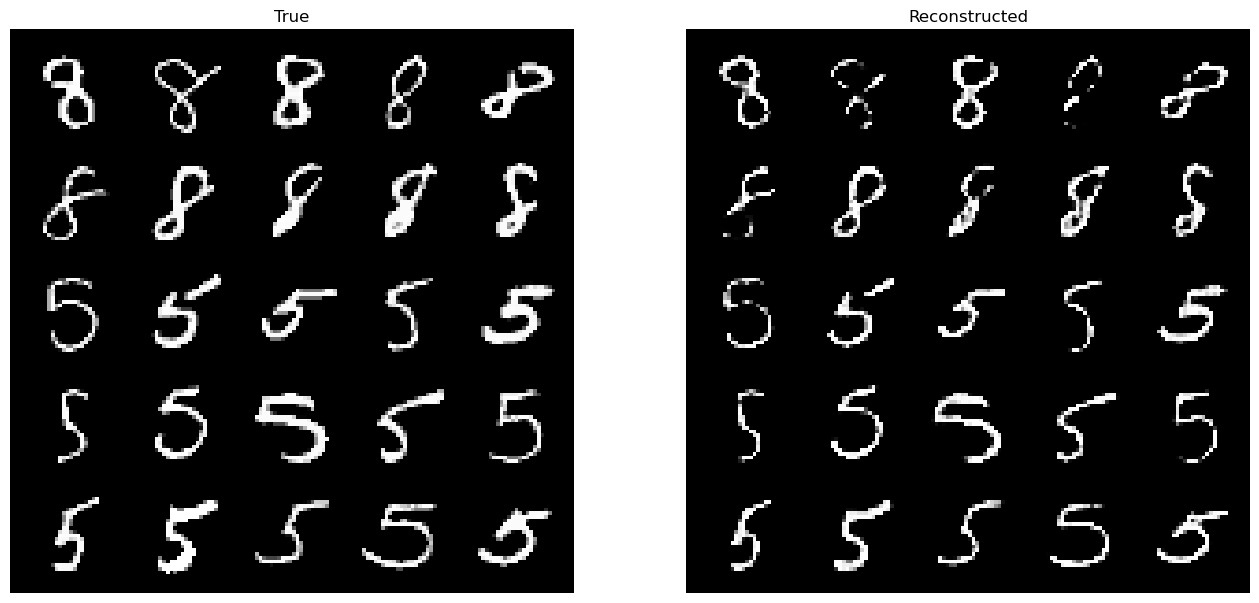

Epoch 7


100%|██████████| 98/98 [00:00<00:00, 174.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


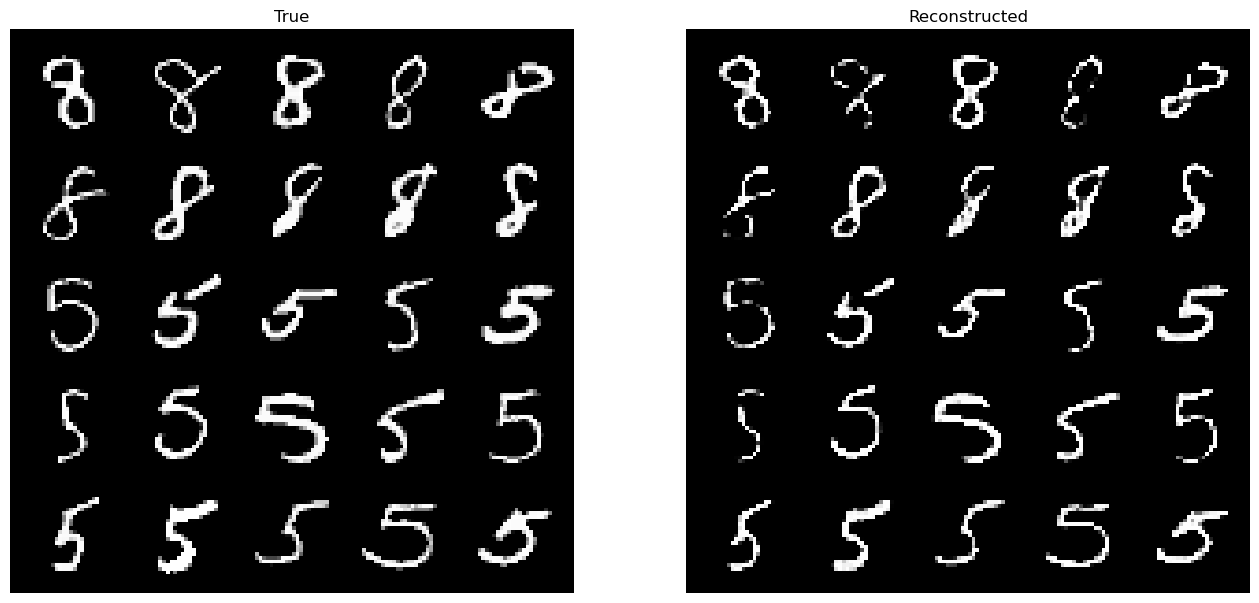

Epoch 8


100%|██████████| 98/98 [00:00<00:00, 176.16it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


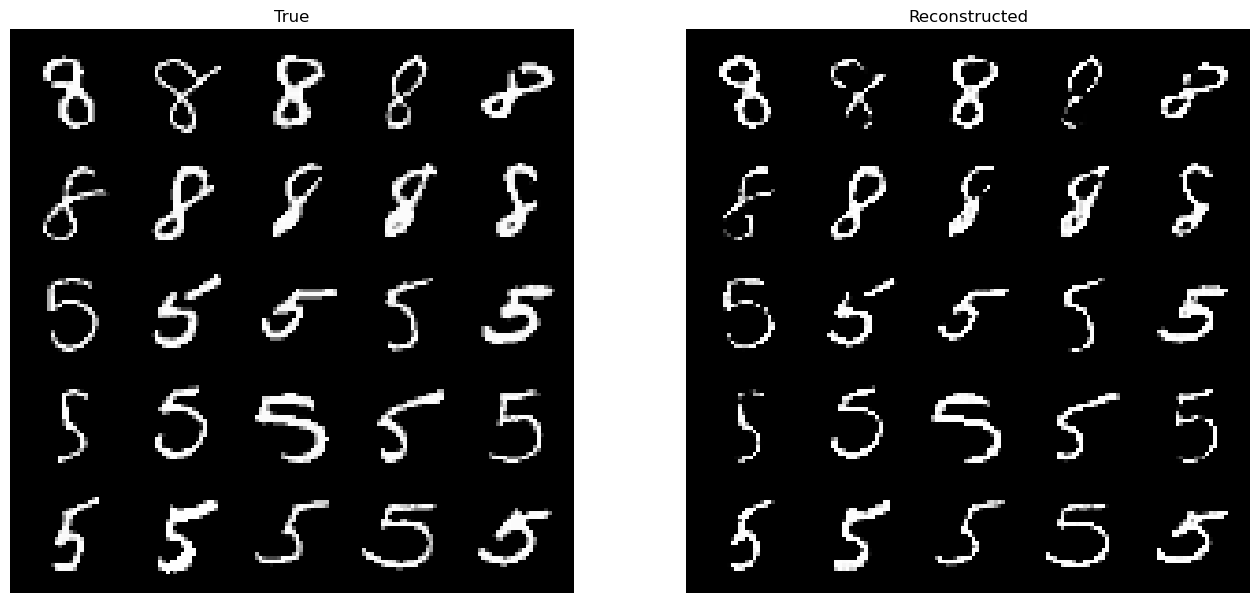

Epoch 9


100%|██████████| 98/98 [00:00<00:00, 174.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


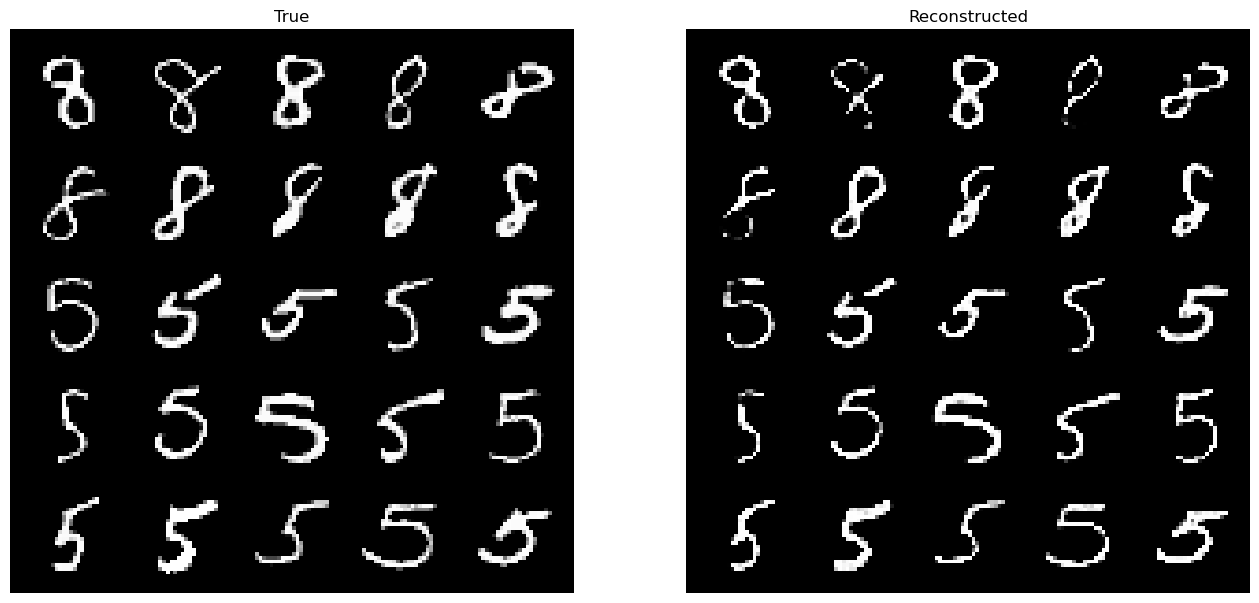

In [1148]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)

from torchvision.utils import make_grid
from tqdm import tqdm
import time

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
   
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())

device = 'cuda'
vae = VAE().to(device)
vae_opt = torch.optim.Adam(vae.parameters(), lr=0.002)
for epoch in range(10):
    print(f"Epoch {epoch}")
    time.sleep(0.5)
    for images in tqdm(ds):
        images = images.to(device)
        vae_opt.zero_grad() # Clear out the gradients
        recon_images, encoding = vae(images)
        loss = reconstruction_loss(recon_images, images) + kl_divergence_loss(encoding).sum()
        loss.backward()
        vae_opt.step()
    plt.subplot(1,2,1)
    show_tensor_images(images)
    plt.title("True")
    plt.subplot(1,2,2)
    show_tensor_images(recon_images)
    plt.title("Reconstructed")
    plt.show()

In [1149]:
recon_images = recon_images.detach().cpu()
recon_images = recon_images.reshape(bs,1,28,28)

In [1150]:
cnn.eval()
with torch.no_grad():
    test_output, last_layer = cnn(recon_images)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()

In [1151]:
len(pred_y)

120

In [1152]:
# vae1=[]
# vae2=[]
# vae3=[]

In [1153]:
vae_c1 = 0
vae_c0 =0
vae_c3 = 0
for i in pred_y:
    if i == b: 
        vae_c0 += 1
    if i == a:
        vae_c1 += 1
    if i ==c:
        vae_c3 +=1
        
list= [gen_c0,gen_c1,gen_c3]

vae1.append(vae_c0) #variable
vae2.append(vae_c1) 
vae3.append(vae_c3)
        

In [1154]:
print(vae1)
print(len(vae1))

[6, 5, 6, 6, 5]
5


In [1097]:
recon_images.shape

torch.Size([120, 1, 28, 28])

In [54]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [55]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [56]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [57]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [58]:
classifer_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, drop_last=True, shuffle=True)

In [65]:
from torch.autograd import Variable
num_epochs = 5
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders)
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            pass
        
        pass
    
    
    pass
train(num_epochs, cnn, classifer_loader)

Epoch [1/5], Step [100/1200], Loss: 0.0428
Epoch [1/5], Step [200/1200], Loss: 0.2063
Epoch [1/5], Step [300/1200], Loss: 0.1129
Epoch [1/5], Step [400/1200], Loss: 0.1562
Epoch [1/5], Step [500/1200], Loss: 0.1125
Epoch [1/5], Step [600/1200], Loss: 0.0446
Epoch [1/5], Step [700/1200], Loss: 0.0089
Epoch [1/5], Step [800/1200], Loss: 0.1282
Epoch [1/5], Step [900/1200], Loss: 0.1650
Epoch [1/5], Step [1000/1200], Loss: 0.1310
Epoch [1/5], Step [1100/1200], Loss: 0.0135
Epoch [1/5], Step [1200/1200], Loss: 0.0712
Epoch [2/5], Step [100/1200], Loss: 0.0276
Epoch [2/5], Step [200/1200], Loss: 0.1183
Epoch [2/5], Step [300/1200], Loss: 0.0226
Epoch [2/5], Step [400/1200], Loss: 0.1967
Epoch [2/5], Step [500/1200], Loss: 0.0925
Epoch [2/5], Step [600/1200], Loss: 0.1278
Epoch [2/5], Step [700/1200], Loss: 0.0536
Epoch [2/5], Step [800/1200], Loss: 0.1488
Epoch [2/5], Step [900/1200], Loss: 0.0283
Epoch [2/5], Step [1000/1200], Loss: 0.0392
Epoch [2/5], Step [1100/1200], Loss: 0.1720
Epoch 

In [ ]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
    pass
test()

In [ ]:
# plt.plot(d_loss)
# plt.plot(d_g_loss)
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Discriminator', 'Adversarial'], loc='center right')
# plt.show()

In [ ]:
# gen1 = []
# gen2 = []
# gen3 = []
#run this after changing the batches

In [74]:
#start run from here

In [179]:
generated = predictions_gen.reshape(bs,1,28,28)

In [180]:
cnn.eval()
with torch.no_grad():
    test_output, last_layer = cnn(generated)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()

In [181]:
# cnn.eval()
# with torch.no_grad():
    
#     correct = 0
#     total = 0
#     for images in ds:
        
#         test_output, last_layer = cnn(images)
#         pred_y = torch.max(test_output, 1)[1].data.squeeze()
#         # accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
#         pass
# print(pred_y)    
# # print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

In [182]:
pred_y

tensor([0, 0, 3, 1, 1, 1, 0, 5, 0, 5, 3, 0, 1, 0, 0, 3, 3, 1, 0, 3, 3, 0, 0, 1,
        3, 3, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 3, 3, 1, 0, 1, 1, 0, 3, 3, 3, 3,
        3, 3, 0, 1, 1, 0, 1, 0, 0, 3, 0, 3, 0, 1, 0, 0, 0, 3, 3, 3, 0, 1, 1, 0,
        1, 3, 3, 3, 0, 3, 0, 3, 1, 0, 0, 0, 1, 0, 3, 0, 1, 3, 3, 3, 0, 3, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 3, 0, 1, 3, 0, 3, 3, 0, 0, 0, 1, 0, 3, 0])

In [183]:
gen_c1 = 0
gen_c0 =0
gen_c3 = 0
for i in pred_y:
    if i == 0:
        gen_c0 += 1
    if i == 1:
        gen_c1 += 1
    if i ==3:
        gen_c3 +=1
        
list= [gen_c0,gen_c1,gen_c3]

gen1.append(gen_c0)
gen2.append(gen_c1)
gen3.append(gen_c3)
        

In [184]:
gen1

[54, 53, 53, 58, 46, 49, 56]

In [407]:
len(gen2)

30

In [186]:
gen3

[53, 44, 57, 43, 52, 37, 37]

In [775]:
np.mean(gen2) #take mean for 5 values

103.33333333333333

In [776]:
np.var(gen2)

67.55555555555556